# Packages

In [32]:
from sklearn.datasets import load_iris
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from pathlib import Path
from keras.models import Sequential, model_from_json
from keras.layers import Activation, Dense
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, BatchNormalization, Flatten, GlobalMaxPooling2D
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import os
import itertools
from tensorboard import notebook
import datetime
from sklearn.preprocessing import StandardScaler

# Data

In [21]:
data = load_iris()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['Target_class'] = data.target 
df['Target_Name']  = df['Target_class'].apply(
    lambda x: data.target_names[x]
)
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Target_class,Target_Name
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa


# Data standardization

In [33]:
features = df.columns.difference(['Target_class','Target_Name']).tolist()
features

['petal length (cm)',
 'petal width (cm)',
 'sepal length (cm)',
 'sepal width (cm)']

In [34]:
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

let's check the scale

In [43]:
df_melt = pd.melt(df, id_vars=['Target_class','Target_Name'], value_vars=features)
df_melt.head()

,Target_class,Target_Name,variable,value
0,0,setosa,petal length (cm),-1.340227
1,0,setosa,petal length (cm),-1.340227
2,0,setosa,petal length (cm),-1.397064
3,0,setosa,petal length (cm),-1.283389
4,0,setosa,petal length (cm),-1.340227


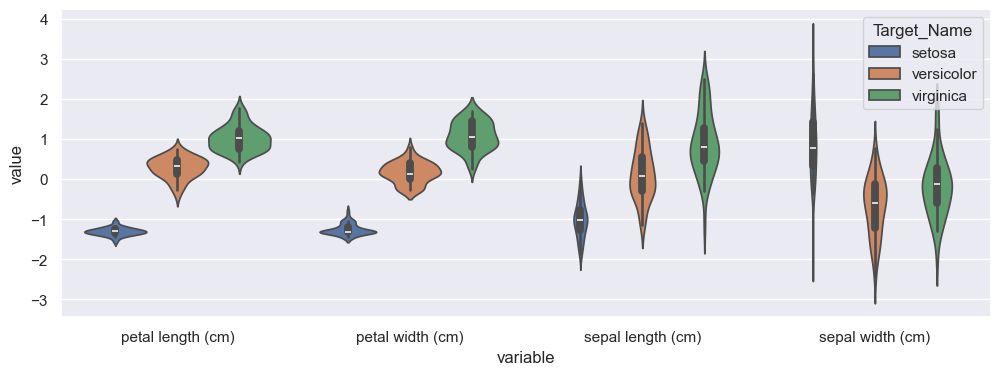

In [57]:
plt.figure(figsize=(12,4))
sns.violinplot(data = df_melt, x='variable',y='value',hue='Target_Name')
plt.show()

visually Petal Lenght and Petal Width are the characteristics that allow to better differentiate each class.

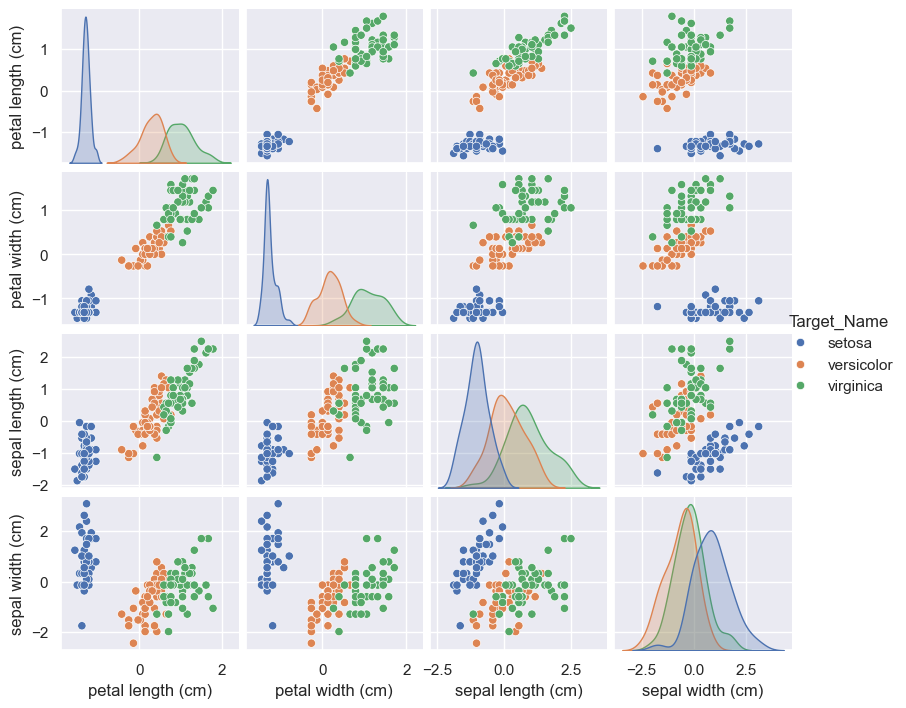

In [58]:
# pairplot

g = sns.pairplot(df[df.columns.difference(['Target_class'])], hue="Target_Name")
g.fig.set_size_inches(9,7)

let's doing some clasification

In [75]:
def model_compile(model):
    reduce_lr = tf.keras.callbacks.LearningRateScheduler(
        lambda x: 0.01*0.9**x
    )

    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=30,
        restore_best_weights=True
    )

    model.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(0.01),
                metrics=['accuracy'])
    return model, reduce_lr, early_stop

In [61]:
def plot_confusion_matrix(cm: np.ndarray,
                          target_names: list,
                          title: str='Confusion matrix',
                          cmap: str=None,
                          normalize: bool=True):
    '''given a sklearn confusion matrix (cm), make a nice plot

    Args:
        cm:           confusion matrix from sklearn.metrics.confusion_matrix

        target_names: given classification classes such as [0, 1, 2]
                      the class names, for example: ['high', 'medium', 'low']

        title:        the text to display at the top of the matrix

        cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                      see http://matplotlib.org/examples/color/colormaps_reference.html
                      plt.get_cmap('jet') or plt.cm.Blues

        normalize:    If False, plot the raw numbers
                      If True, plot the proportions
    '''

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(7, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [69]:
D = df[features].shape[1]
outpus = len(df['Target_class'].unique())
D, outpus

(4, 3)

In [70]:
df[features].shape

(150, 4)

In [110]:
model = Sequential(name='Clasification_iris')
model.add(Dense(32, input_shape=(D,), activation='linear'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(outpus,activation='softmax'))
model.summary()

model, reduce_lr, early_stop = model_compile(model)
with tf.device('/device:GPU:0'):
  r = model.fit(
        df[features],
        df['Target_class'],
        validation_split=0.2,
        verbose=1,
        epochs=100,
        callbacks=[early_stop],
        batch_size=32
    )

Model: "Clasification_iris"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_59 (Dense)            (None, 32)                160       
                                                                 
 batch_normalization_8 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dropout_18 (Dropout)        (None, 32)                0         
                                                                 
 dense_60 (Dense)            (None, 32)                1056      
                                                                 
 dense_61 (Dense)            (None, 32)                1056      
                                                                 
 dense_62 (Dense)            (None, 32)                1056      
                                                

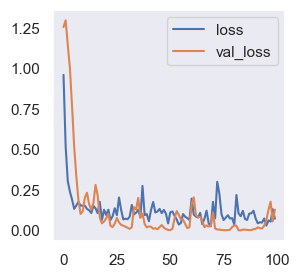

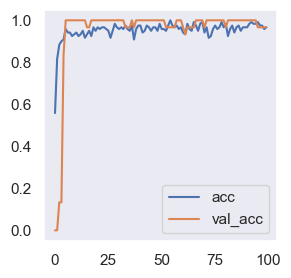

In [111]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()
plt.show()

plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'],label='val_acc')
plt.legend()
plt.show()

Our model has a performance accuracy of 98%

5/5 [==============================] - 0s 4ms/step


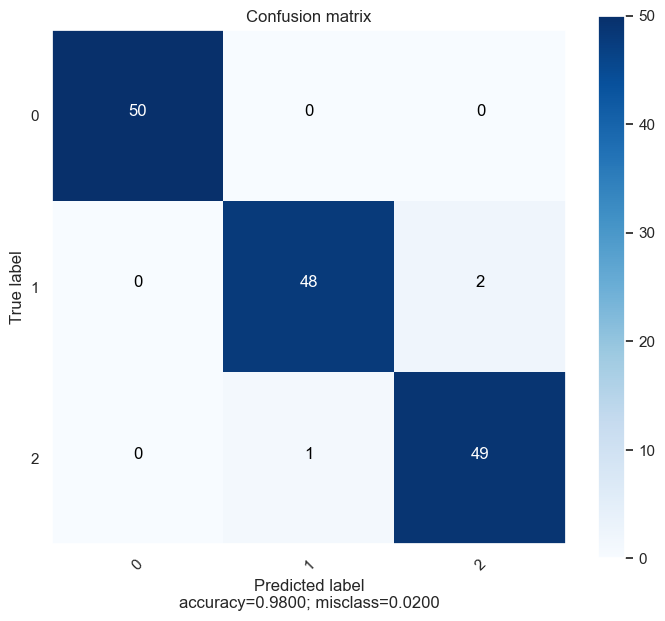

In [115]:
y_predict = model.predict(df[features]).argmax(axis=1)
sns.set_style("dark")

plot_confusion_matrix(
    cm=confusion_matrix(df['Target_class'], y_predict),
    target_names=list(range(outpus)),
    title='Confusion matrix',
    normalize=False
    )

# What about clustering?

# without PCA

In [138]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [120]:
import warnings
warnings.filterwarnings('ignore')

n_clusters: determines the number K
  of clusters to be generated.

init: strategy to assign the initial centroids. By default, 'k-means++' is used, a strategy that tries to move the centroids as far away as possible, facilitating convergence. However, this strategy can slow down the process when there is a lot of data, if this happens, it is better to use 'random'.

n_init: determines the number of times the process will be repeated, each time with a different initial random assignment. It is recommended that this last value be high, between 10-25, so as not to obtain suboptimal results due to an unlucky initiation of the process.

max_iter: maximum number of iterations allowed.

random_state: seed to guarantee reproducibility of the results.

In [136]:
X = df[features].values
y = df['Target_class'].values

n_clusters = 10
# model_kmeans =  KMeans(n_clusters=n_clusters , n_init=25, random_state=123)
# model_kmeans.fit(X=X)

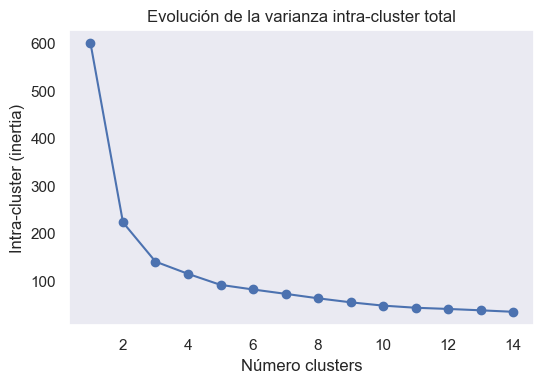

In [137]:
# elbow method
range_n_clusters = range(1, 15)
inertias = []

for n_clusters in range_n_clusters:
    model_kmeans = KMeans(
                        n_clusters   = n_clusters, 
                        n_init       = 25, 
                        random_state = 123
                    )
    model_kmeans.fit(X)
    inertias.append(model_kmeans.inertia_)

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters, inertias, marker='o')
ax.set_title("Evolución de la varianza intra-cluster total")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Intra-cluster (inertia)');

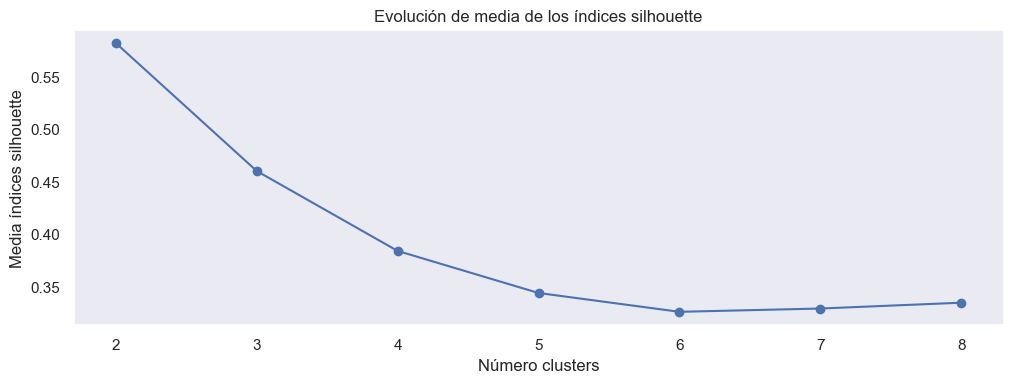

In [143]:
range_n_clusters = range(2, n_clusters)
valores_medios_silhouette = []

for n_clusters in range_n_clusters:
    modelo_kmeans = KMeans(
                        n_clusters   = n_clusters, 
                        n_init       = 25, 
                        random_state = 123
                    )
    cluster_labels = modelo_kmeans.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    valores_medios_silhouette.append(silhouette_avg)
    
fig, ax = plt.subplots(1, 1, figsize=(12, 3.84))
ax.plot(range_n_clusters, valores_medios_silhouette, marker='o')
ax.set_title("Evolución de media de los índices silhouette")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Media índices silhouette');

The elbow method suggests k=3, the Silhoutte method k=2

In [147]:
def plot_orig_predic(X,y, y_predict):
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))

    # Grupos originales
    for i in np.unique(y):
        ax[0].scatter(
            x = X[y == i, 0],
            y = X[y == i, 1], 
            c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
            marker    = 'o',
            edgecolor = 'black', 
            label= f"Grupo {i}"
        )
        
    ax[0].set_title('Original Classes')
    ax[0].legend();

    for i in np.unique(y_predict):
        ax[1].scatter(
            x = X[y_predict == i, 0],
            y = X[y_predict == i, 1], 
            c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
            marker    = 'o',
            edgecolor = 'black', 
            label= f"Cluster {i}"
        )
        
    ax[1].scatter(
        x = model_kmeans.cluster_centers_[:, 0],
        y = model_kmeans.cluster_centers_[:, 1], 
        c = 'black',
        s = 200,
        marker = '*',
        label  = 'centroides'
    )
    ax[1].set_title('KMeans Clusters')
    ax[1].legend();

## kmeans k=2

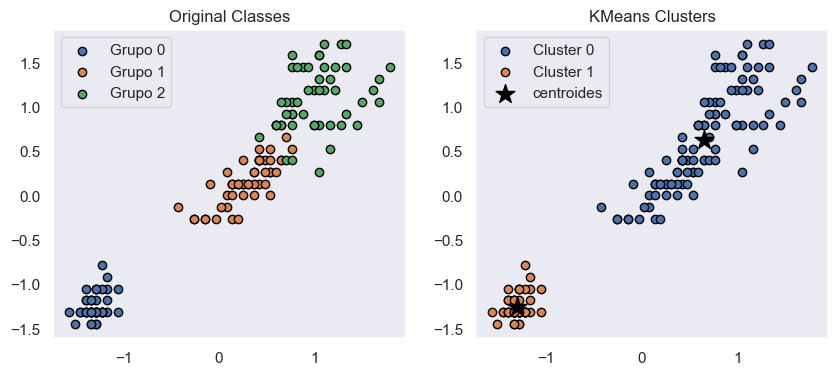

In [151]:
model_kmeans =  KMeans(n_clusters=2 , n_init=25, random_state=123)
model_kmeans.fit(X=X)
y_predict = model_kmeans.predict(X)
plot_orig_predic(X,y,y_predict)

## kmeans = 3

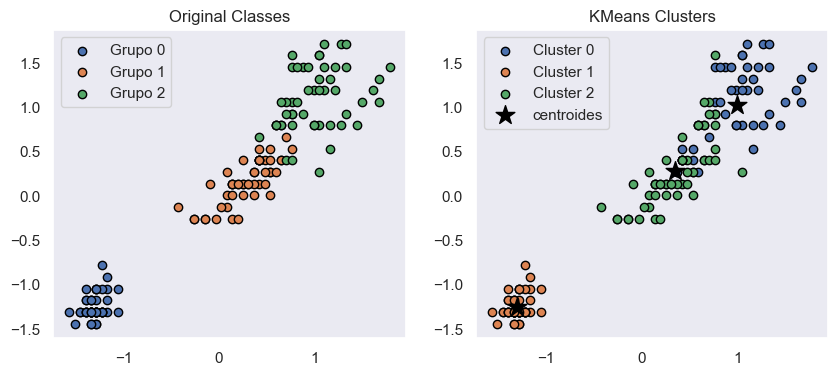

In [154]:
model_kmeans =  KMeans(n_clusters=3 , n_init=25, random_state=123)
model_kmeans.fit(X=X)
y_predict = model_kmeans.predict(X)
plot_orig_predic(X,y,y_predict)

let us evaluate the k=3 with the confusion matrix

let's adjust the classes according to the original distribution of the problem

In [157]:
y_predict_adj = np.array(
    [0 if i == 1 else 1 if i == 2 else 2 for i in y_predict]
)

y_predict_adj 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2,
       2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1])

compared to the original classes, the k=3 achieves an accuracy of 83%.

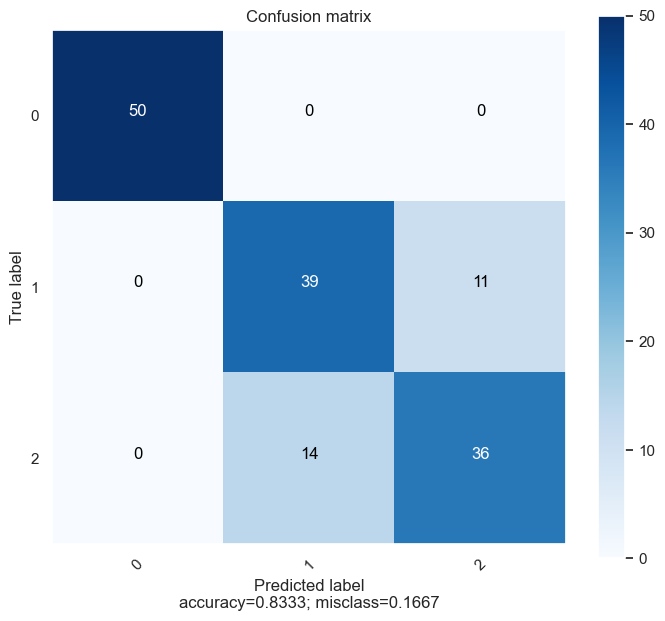

In [159]:
plot_confusion_matrix(
    cm=confusion_matrix(df['Target_class'], y_predict_adj),
    target_names=list(range(outpus)),
    title='Confusion matrix',
    normalize=False
    )

# With PCA

Principal Component Analysis (PCA) is a dimensionality reduction method that simplifies the complexity of multidimensional spaces while preserving their information.

**Optimal number of principal components**

 A very widespread way of proceeding consists of evaluating the proportion of variance explained and selecting the minimum number of components beyond which the increase is no longer substantial.

In [165]:
from sklearn.decomposition import PCA

In [164]:
D = df[features].shape[1]
D

4

In [166]:
model_PCA = PCA(n_components=D)
model_PCA.fit(df[features])

PCA(n_components=4)

## Interpretations

eigenvector of each PCA, The rows correspond to the principal components (ordered from highest to lowest variance explained). The rows correspond to the input variables.

In [167]:
pd.DataFrame(
    data    = model_PCA.components_,
    columns = df[features].columns,
    index   = ['PC1', 'PC2', 'PC3', 'PC4']
)

,petal length (cm),petal width (cm),sepal length (cm),sepal width (cm)
PC1,0.580413,0.564857,0.521066,-0.269347
PC2,0.024492,0.066942,0.377418,0.923296
PC3,-0.142126,-0.634273,0.719566,-0.244382
PC4,0.801449,-0.523597,-0.261286,0.123510


Once the principal components have been calculated, it is possible to know the variance explained by each of them, the proportion with respect to the total and the proportion of accumulated variance. This information is stored in the explained_variance_ and explained_variance_ratio_ attributes of the model.

The first component explains 73% of the variance observed in the data and the second component explains 23%.

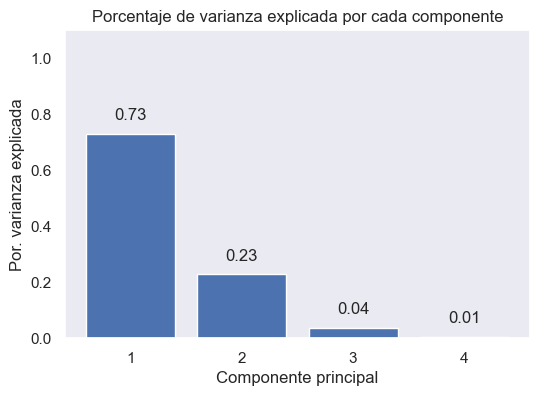

In [168]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.bar(
    x      = np.arange(model_PCA.n_components_) + 1,
    height = model_PCA.explained_variance_ratio_
)

for x, y in zip(np.arange(len(df.columns)) + 1, model_PCA.explained_variance_ratio_):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )

ax.set_xticks(np.arange(model_PCA.n_components_) + 1)
ax.set_ylim(0, 1.1)
ax.set_title('Porcentaje de varianza explicada por cada componente')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza explicada');

using only the first two components would explain 96% of the observed variance.

[0.72962445 0.95813207 0.99482129 1.        ]


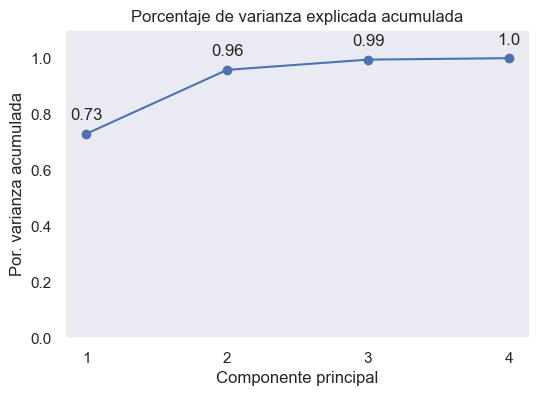

In [169]:
prop_varianza_acum = model_PCA.explained_variance_ratio_.cumsum()

print(prop_varianza_acum)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.plot(
    np.arange(len(df[features].columns)) + 1,
    prop_varianza_acum,
    marker = 'o'
)

for x, y in zip(np.arange(len(df[features].columns)) + 1, prop_varianza_acum):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )
    
ax.set_ylim(0, 1.1)
ax.set_xticks(np.arange(model_PCA.n_components_) + 1)
ax.set_title('Porcentaje de varianza explicada acumulada')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza acumulada');

In [183]:
df_PCA = df[features].copy()
df_PCA[features] = model_PCA.transform(df[features])
df_PCA

,petal length (cm),petal width (cm),sepal length (cm),sepal width (cm)
0,-2.264703,0.480027,0.127706,-0.024168
1,-2.080961,-0.674134,0.234609,-0.103007
2,-2.364229,-0.341908,-0.044201,-0.028377
3,-2.299384,-0.597395,-0.091290,0.065956
4,-2.389842,0.646835,-0.015738,0.035923
...,...,...,...,...
145,1.870503,0.386966,-0.256274,-0.389257
146,1.564580,-0.896687,0.026371,-0.220192
147,1.521170,0.269069,-0.180178,-0.119171
148,1.372788,1.011254,-0.933395,-0.026129


In [187]:
proyecciones = model_PCA.transform(X=df[features])
proyecciones = pd.DataFrame(
    proyecciones,
    columns = ['PC1', 'PC2', 'PC3', 'PC4'],
    index   = df.index
)
proyecciones.head()

,PC1,PC2,PC3,PC4
0,-2.264703,0.480027,0.127706,-0.024168
1,-2.080961,-0.674134,0.234609,-0.103007
2,-2.364229,-0.341908,-0.044201,-0.028377
3,-2.299384,-0.597395,-0.091290,0.065956
4,-2.389842,0.646835,-0.015738,0.035923


In [188]:
# only use PC1 and PC2
proyecciones_2dim = proyecciones[['PC1','PC2']].copy()

## elbow method

In [190]:
X = proyecciones_2dim.values
n_clusters = 10

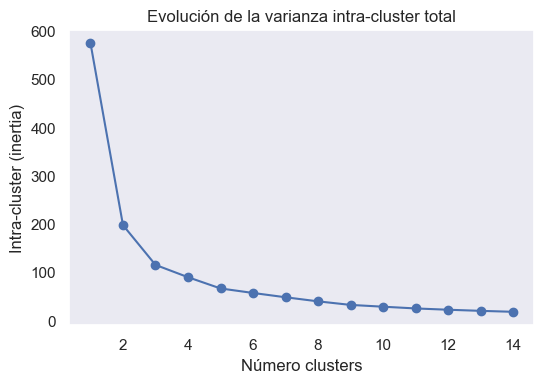

In [191]:
# elbow method
range_n_clusters = range(1, 15)
inertias = []

for n_clusters in range_n_clusters:
    model_kmeans = KMeans(
                        n_clusters   = n_clusters, 
                        n_init       = 25, 
                        random_state = 123
                    )
    model_kmeans.fit(X)
    inertias.append(model_kmeans.inertia_)

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters, inertias, marker='o')
ax.set_title("Evolución de la varianza intra-cluster total")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Intra-cluster (inertia)');

## silhouette

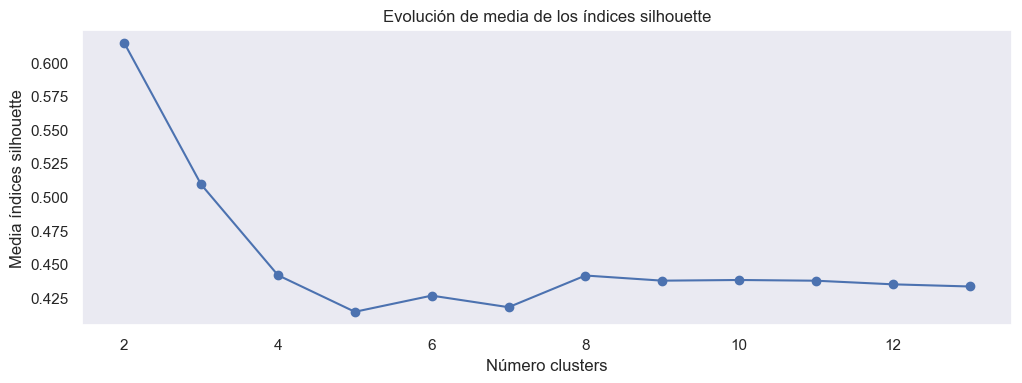

In [192]:
range_n_clusters = range(2, n_clusters)
valores_medios_silhouette = []

for n_clusters in range_n_clusters:
    modelo_kmeans = KMeans(
                        n_clusters   = n_clusters, 
                        n_init       = 25, 
                        random_state = 123
                    )
    cluster_labels = modelo_kmeans.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    valores_medios_silhouette.append(silhouette_avg)
    
fig, ax = plt.subplots(1, 1, figsize=(12, 3.84))
ax.plot(range_n_clusters, valores_medios_silhouette, marker='o')
ax.set_title("Evolución de media de los índices silhouette")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Media índices silhouette');

## kmean k=2

In [196]:
X.shape

(150, 2)

In [201]:
y = df['Target_class']

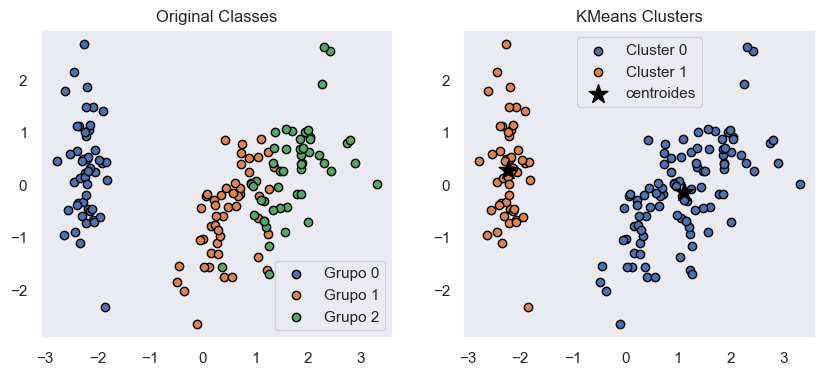

In [202]:
model_kmeans =  KMeans(n_clusters=2 , n_init=25, random_state=123)
model_kmeans.fit(X=X)
y_predict = model_kmeans.predict(X)
plot_orig_predic(X,y,y_predict)

## kmean k=3

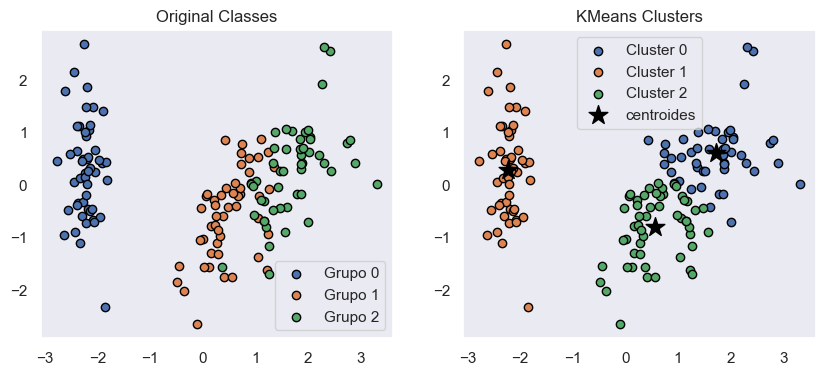

In [205]:
model_kmeans =  KMeans(n_clusters=3 , n_init=25, random_state=123)
model_kmeans.fit(X=X)
y_predict = model_kmeans.predict(X)
plot_orig_predic(X,y,y_predict)

In [206]:
y_predict_adj = np.array(
    [0 if i == 1 else 1 if i == 2 else 2 for i in y_predict]
)

y_predict_adj 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2,
       2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1])

using only two dimensions you get the same accuracy of 83%, it may seem so far that I am doing nothing but it would need to be tested with high dimensional data.

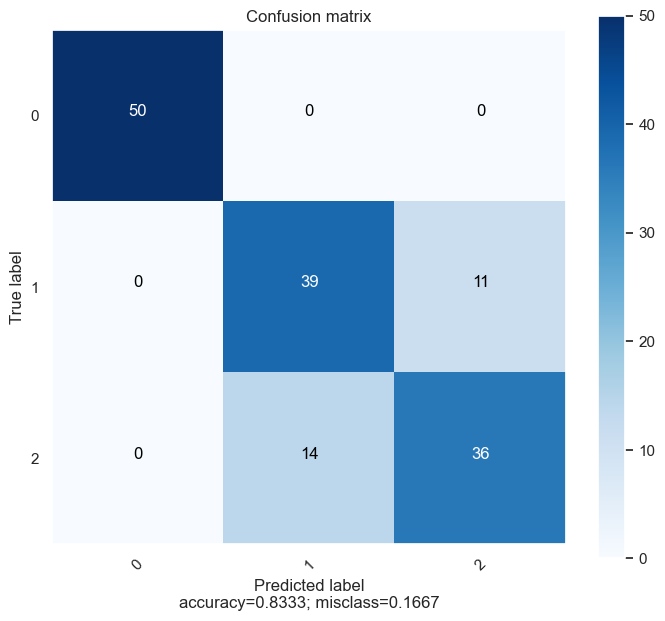

In [209]:
plot_confusion_matrix(
    cm=confusion_matrix(df['Target_class'], y_predict_adj),
    target_names=list(range(outpus)),
    title='Confusion matrix',
    normalize=False
    )

# conclusion

The results obtained by applying K-means to the Iris dataset suggest that this algorithm can be a valuable tool for discovering hidden patterns in unlabeled data. The fact that the algorithm has identified three distinct groups, coinciding with the real classes, indicates that K-means is capable of revealing inherent structures in the data, which is fundamental for classification tasks and exploratory analysis.

# webgraphy

https://cienciadedatos.net/documentos/py20-clustering-con-python

https://cienciadedatos.net/documentos/py19-pca-python